<a href="https://colab.research.google.com/github/Deepak5j/GeneratingFashionDesigns/blob/master/GeneratingFashionDesigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



* Data set from https://github.com/zalandoresearch/fashion-mnist
* Guide from https://github.com/R-Suresh/GAN_fashion_MNIST/blob/master/gan.py

In [0]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)              

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.942401, acc.: 34.38%] [G loss: 0.882323]


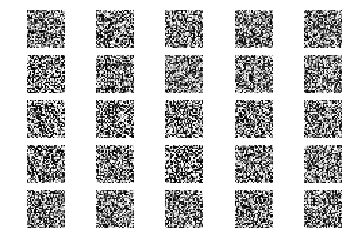

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.532145, acc.: 78.12%] [G loss: 0.851845]
2 [D loss: 0.350166, acc.: 92.19%] [G loss: 1.048684]
3 [D loss: 0.247914, acc.: 98.44%] [G loss: 1.383301]
4 [D loss: 0.190892, acc.: 98.44%] [G loss: 1.542030]
5 [D loss: 0.157113, acc.: 98.44%] [G loss: 1.779284]
6 [D loss: 0.131826, acc.: 100.00%] [G loss: 2.030546]
7 [D loss: 0.114005, acc.: 100.00%] [G loss: 2.292489]
8 [D loss: 0.094291, acc.: 100.00%] [G loss: 2.400527]
9 [D loss: 0.071701, acc.: 100.00%] [G loss: 2.557395]
10 [D loss: 0.070585, acc.: 100.00%] [G loss: 2.733273]
11 [D loss: 0.047373, acc.: 100.00%] [G loss: 2.947431]
12 [D loss: 0.088788, acc.: 98.44%] [G loss: 2.986723]
13 [D loss: 0.040839, acc.: 100.00%] [G loss: 3.218021]
14 [D loss: 0.040420, acc.: 100.00%] [G loss: 3.297882]
15 [D loss: 0.032101, acc.: 100.00%] [G loss: 3.469454]
16 [D loss: 0.034937, acc.: 100.00%] [G loss: 3.642395]
17 [D loss: 0.064363, acc.: 98.44%] [G loss: 3.602773]
18 [D loss: 0.023557, acc.: 100.00%] [G loss: 3.829790]
19 [D lo

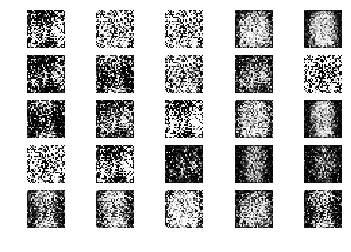

201 [D loss: 0.344130, acc.: 82.81%] [G loss: 4.575136]
202 [D loss: 0.139987, acc.: 96.88%] [G loss: 4.612463]
203 [D loss: 0.288056, acc.: 87.50%] [G loss: 4.610595]
204 [D loss: 0.142236, acc.: 95.31%] [G loss: 5.175498]
205 [D loss: 0.352949, acc.: 82.81%] [G loss: 3.941058]
206 [D loss: 0.306929, acc.: 82.81%] [G loss: 6.756436]
207 [D loss: 0.809125, acc.: 60.94%] [G loss: 4.651640]
208 [D loss: 0.200842, acc.: 96.88%] [G loss: 5.019468]
209 [D loss: 0.163185, acc.: 96.88%] [G loss: 4.438434]
210 [D loss: 0.159726, acc.: 96.88%] [G loss: 4.636961]
211 [D loss: 0.187528, acc.: 98.44%] [G loss: 5.106808]
212 [D loss: 0.317068, acc.: 84.38%] [G loss: 6.028677]
213 [D loss: 0.705500, acc.: 57.81%] [G loss: 5.075567]
214 [D loss: 0.133414, acc.: 93.75%] [G loss: 4.990358]
215 [D loss: 0.191471, acc.: 93.75%] [G loss: 5.544425]
216 [D loss: 0.229371, acc.: 92.19%] [G loss: 4.491355]
217 [D loss: 0.187828, acc.: 93.75%] [G loss: 4.440845]
218 [D loss: 0.317562, acc.: 87.50%] [G loss: 4.

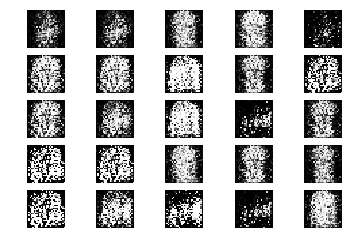

401 [D loss: 0.437169, acc.: 76.56%] [G loss: 3.102488]
402 [D loss: 0.484495, acc.: 76.56%] [G loss: 5.105462]
403 [D loss: 0.653340, acc.: 76.56%] [G loss: 5.020743]
404 [D loss: 0.332314, acc.: 89.06%] [G loss: 4.973294]
405 [D loss: 0.357139, acc.: 84.38%] [G loss: 4.140550]
406 [D loss: 0.306783, acc.: 89.06%] [G loss: 3.890465]
407 [D loss: 0.372408, acc.: 85.94%] [G loss: 4.568715]
408 [D loss: 0.888728, acc.: 62.50%] [G loss: 4.525713]
409 [D loss: 0.213657, acc.: 95.31%] [G loss: 5.195587]
410 [D loss: 0.389050, acc.: 81.25%] [G loss: 3.474311]
411 [D loss: 0.338890, acc.: 95.31%] [G loss: 3.335288]
412 [D loss: 0.304645, acc.: 89.06%] [G loss: 3.638189]
413 [D loss: 0.363704, acc.: 87.50%] [G loss: 3.720090]
414 [D loss: 0.467656, acc.: 79.69%] [G loss: 3.130999]
415 [D loss: 0.442683, acc.: 78.12%] [G loss: 3.880039]
416 [D loss: 0.353444, acc.: 84.38%] [G loss: 4.174345]
417 [D loss: 0.463400, acc.: 82.81%] [G loss: 2.994347]
418 [D loss: 0.434108, acc.: 79.69%] [G loss: 4.

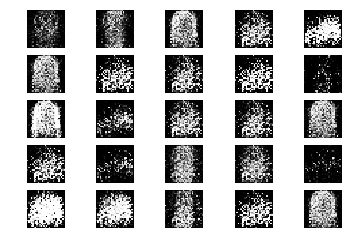

601 [D loss: 0.595486, acc.: 73.44%] [G loss: 2.378577]
602 [D loss: 0.538649, acc.: 81.25%] [G loss: 2.269011]
603 [D loss: 0.813409, acc.: 68.75%] [G loss: 1.930815]
604 [D loss: 0.773201, acc.: 51.56%] [G loss: 1.827596]
605 [D loss: 0.436271, acc.: 79.69%] [G loss: 2.300298]
606 [D loss: 0.618034, acc.: 68.75%] [G loss: 2.232050]
607 [D loss: 0.480386, acc.: 76.56%] [G loss: 2.421107]
608 [D loss: 0.632673, acc.: 57.81%] [G loss: 2.589448]
609 [D loss: 0.578925, acc.: 78.12%] [G loss: 1.757240]
610 [D loss: 0.502342, acc.: 79.69%] [G loss: 1.925797]
611 [D loss: 0.628424, acc.: 67.19%] [G loss: 2.086035]
612 [D loss: 0.630353, acc.: 67.19%] [G loss: 2.029521]
613 [D loss: 0.447833, acc.: 87.50%] [G loss: 1.861620]
614 [D loss: 0.600382, acc.: 71.88%] [G loss: 1.570978]
615 [D loss: 0.454874, acc.: 71.88%] [G loss: 2.045971]
616 [D loss: 0.531827, acc.: 73.44%] [G loss: 2.016459]
617 [D loss: 0.582904, acc.: 71.88%] [G loss: 1.778898]
618 [D loss: 0.559936, acc.: 67.19%] [G loss: 1.

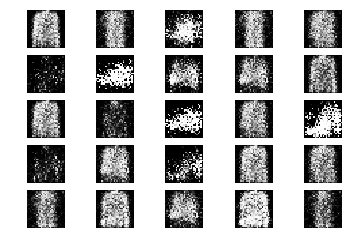

801 [D loss: 0.604738, acc.: 57.81%] [G loss: 1.296003]
802 [D loss: 0.579476, acc.: 70.31%] [G loss: 1.410803]
803 [D loss: 0.463009, acc.: 81.25%] [G loss: 1.364436]
804 [D loss: 0.456138, acc.: 82.81%] [G loss: 1.422685]
805 [D loss: 0.505369, acc.: 70.31%] [G loss: 1.672716]
806 [D loss: 0.487205, acc.: 76.56%] [G loss: 1.523318]
807 [D loss: 0.603164, acc.: 65.62%] [G loss: 1.730850]
808 [D loss: 0.504501, acc.: 78.12%] [G loss: 1.736835]
809 [D loss: 0.421247, acc.: 81.25%] [G loss: 1.836869]
810 [D loss: 0.437017, acc.: 79.69%] [G loss: 1.852574]
811 [D loss: 0.536362, acc.: 71.88%] [G loss: 1.611740]
812 [D loss: 0.615820, acc.: 68.75%] [G loss: 1.812127]
813 [D loss: 0.414149, acc.: 85.94%] [G loss: 1.837554]
814 [D loss: 0.542454, acc.: 73.44%] [G loss: 1.596784]
815 [D loss: 0.459425, acc.: 82.81%] [G loss: 1.532264]
816 [D loss: 0.537774, acc.: 71.88%] [G loss: 1.940499]
817 [D loss: 0.391370, acc.: 87.50%] [G loss: 1.938109]
818 [D loss: 0.531673, acc.: 70.31%] [G loss: 1.

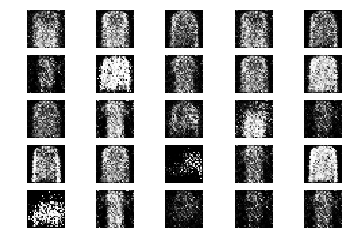

1001 [D loss: 0.530904, acc.: 70.31%] [G loss: 1.493204]
1002 [D loss: 0.586026, acc.: 62.50%] [G loss: 1.675319]
1003 [D loss: 0.491081, acc.: 79.69%] [G loss: 1.379562]
1004 [D loss: 0.434099, acc.: 82.81%] [G loss: 1.434852]
1005 [D loss: 0.526768, acc.: 81.25%] [G loss: 1.410356]
1006 [D loss: 0.470801, acc.: 78.12%] [G loss: 1.550195]
1007 [D loss: 0.490717, acc.: 79.69%] [G loss: 1.745849]
1008 [D loss: 0.443870, acc.: 87.50%] [G loss: 1.778746]
1009 [D loss: 0.670065, acc.: 67.19%] [G loss: 1.570450]
1010 [D loss: 0.499756, acc.: 81.25%] [G loss: 1.666365]
1011 [D loss: 0.517615, acc.: 76.56%] [G loss: 1.897083]
1012 [D loss: 0.469922, acc.: 79.69%] [G loss: 1.558094]
1013 [D loss: 0.663234, acc.: 65.62%] [G loss: 1.440689]
1014 [D loss: 0.630163, acc.: 71.88%] [G loss: 1.566068]
1015 [D loss: 0.479075, acc.: 84.38%] [G loss: 1.645360]
1016 [D loss: 0.476140, acc.: 79.69%] [G loss: 2.017879]
1017 [D loss: 0.425707, acc.: 85.94%] [G loss: 1.749086]
1018 [D loss: 0.449268, acc.: 7

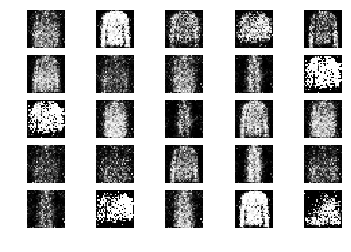

1201 [D loss: 0.537817, acc.: 81.25%] [G loss: 1.235786]
1202 [D loss: 0.509158, acc.: 79.69%] [G loss: 1.209205]
1203 [D loss: 0.541128, acc.: 70.31%] [G loss: 1.333580]
1204 [D loss: 0.665037, acc.: 64.06%] [G loss: 1.207921]
1205 [D loss: 0.568303, acc.: 70.31%] [G loss: 1.214048]
1206 [D loss: 0.460709, acc.: 85.94%] [G loss: 1.251524]
1207 [D loss: 0.545651, acc.: 70.31%] [G loss: 1.216107]
1208 [D loss: 0.580931, acc.: 71.88%] [G loss: 1.447519]
1209 [D loss: 0.519583, acc.: 73.44%] [G loss: 1.537538]
1210 [D loss: 0.577558, acc.: 71.88%] [G loss: 1.258783]
1211 [D loss: 0.513553, acc.: 73.44%] [G loss: 1.167672]
1212 [D loss: 0.419046, acc.: 85.94%] [G loss: 1.304896]
1213 [D loss: 0.461860, acc.: 82.81%] [G loss: 1.333235]
1214 [D loss: 0.590850, acc.: 73.44%] [G loss: 1.167301]
1215 [D loss: 0.598649, acc.: 71.88%] [G loss: 1.295017]
1216 [D loss: 0.513104, acc.: 73.44%] [G loss: 1.293607]
1217 [D loss: 0.531966, acc.: 71.88%] [G loss: 1.302066]
1218 [D loss: 0.488429, acc.: 7

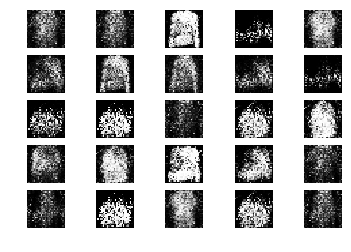

1401 [D loss: 0.555598, acc.: 70.31%] [G loss: 1.392393]
1402 [D loss: 0.513137, acc.: 75.00%] [G loss: 1.277534]
1403 [D loss: 0.583564, acc.: 68.75%] [G loss: 1.285153]
1404 [D loss: 0.578499, acc.: 68.75%] [G loss: 1.280094]
1405 [D loss: 0.473716, acc.: 76.56%] [G loss: 1.190748]
1406 [D loss: 0.527120, acc.: 79.69%] [G loss: 1.192217]
1407 [D loss: 0.517663, acc.: 71.88%] [G loss: 1.329763]
1408 [D loss: 0.548019, acc.: 70.31%] [G loss: 1.249475]
1409 [D loss: 0.552119, acc.: 73.44%] [G loss: 1.173863]
1410 [D loss: 0.436562, acc.: 87.50%] [G loss: 1.193259]
1411 [D loss: 0.573302, acc.: 71.88%] [G loss: 1.286477]
1412 [D loss: 0.629454, acc.: 65.62%] [G loss: 1.285142]
1413 [D loss: 0.443537, acc.: 84.38%] [G loss: 1.354223]
1414 [D loss: 0.465277, acc.: 81.25%] [G loss: 1.296422]
1415 [D loss: 0.559484, acc.: 71.88%] [G loss: 1.327908]
1416 [D loss: 0.643281, acc.: 65.62%] [G loss: 1.277279]
1417 [D loss: 0.580326, acc.: 67.19%] [G loss: 1.344682]
1418 [D loss: 0.553674, acc.: 7

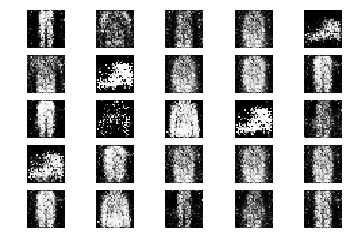

1601 [D loss: 0.579584, acc.: 68.75%] [G loss: 1.206028]
1602 [D loss: 0.460682, acc.: 79.69%] [G loss: 1.121315]
1603 [D loss: 0.654098, acc.: 53.12%] [G loss: 1.035681]
1604 [D loss: 0.457201, acc.: 82.81%] [G loss: 1.447661]
1605 [D loss: 0.533257, acc.: 71.88%] [G loss: 1.339907]
1606 [D loss: 0.553495, acc.: 73.44%] [G loss: 1.246555]
1607 [D loss: 0.660688, acc.: 56.25%] [G loss: 1.176879]
1608 [D loss: 0.566787, acc.: 70.31%] [G loss: 1.401838]
1609 [D loss: 0.558507, acc.: 71.88%] [G loss: 1.273923]
1610 [D loss: 0.583569, acc.: 68.75%] [G loss: 1.246501]
1611 [D loss: 0.556019, acc.: 73.44%] [G loss: 1.181508]
1612 [D loss: 0.558208, acc.: 70.31%] [G loss: 1.116297]
1613 [D loss: 0.653923, acc.: 60.94%] [G loss: 1.530577]
1614 [D loss: 0.606828, acc.: 67.19%] [G loss: 1.180121]
1615 [D loss: 0.644250, acc.: 57.81%] [G loss: 1.348789]
1616 [D loss: 0.712126, acc.: 57.81%] [G loss: 1.172670]
1617 [D loss: 0.590478, acc.: 62.50%] [G loss: 1.378752]
1618 [D loss: 0.708456, acc.: 5

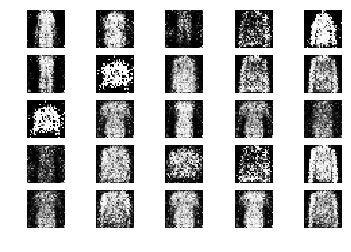

1801 [D loss: 0.575083, acc.: 76.56%] [G loss: 1.391522]
1802 [D loss: 0.604110, acc.: 71.88%] [G loss: 1.217916]
1803 [D loss: 0.593581, acc.: 65.62%] [G loss: 1.324761]
1804 [D loss: 0.553064, acc.: 78.12%] [G loss: 1.427381]
1805 [D loss: 0.596651, acc.: 73.44%] [G loss: 1.199372]
1806 [D loss: 0.577350, acc.: 76.56%] [G loss: 1.335979]
1807 [D loss: 0.606203, acc.: 71.88%] [G loss: 1.599055]
1808 [D loss: 0.626199, acc.: 67.19%] [G loss: 1.292730]
1809 [D loss: 0.573092, acc.: 75.00%] [G loss: 1.241414]
1810 [D loss: 0.535133, acc.: 76.56%] [G loss: 1.290533]
1811 [D loss: 0.569213, acc.: 70.31%] [G loss: 1.244240]
1812 [D loss: 0.536311, acc.: 76.56%] [G loss: 1.241320]
1813 [D loss: 0.560703, acc.: 67.19%] [G loss: 1.315529]
1814 [D loss: 0.617948, acc.: 56.25%] [G loss: 1.278893]
1815 [D loss: 0.545196, acc.: 75.00%] [G loss: 1.254682]
1816 [D loss: 0.554502, acc.: 75.00%] [G loss: 1.503430]
1817 [D loss: 0.458140, acc.: 75.00%] [G loss: 1.467719]
1818 [D loss: 0.500726, acc.: 8

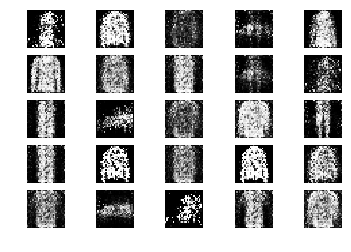

2001 [D loss: 0.510993, acc.: 73.44%] [G loss: 1.352915]
2002 [D loss: 0.648029, acc.: 68.75%] [G loss: 1.184170]
2003 [D loss: 0.547820, acc.: 78.12%] [G loss: 1.236919]
2004 [D loss: 0.521521, acc.: 73.44%] [G loss: 1.257610]
2005 [D loss: 0.560025, acc.: 71.88%] [G loss: 1.406652]
2006 [D loss: 0.476194, acc.: 82.81%] [G loss: 1.317467]
2007 [D loss: 0.591567, acc.: 67.19%] [G loss: 1.471861]
2008 [D loss: 0.592166, acc.: 71.88%] [G loss: 1.281103]
2009 [D loss: 0.599992, acc.: 59.38%] [G loss: 1.471685]
2010 [D loss: 0.531502, acc.: 76.56%] [G loss: 1.486932]
2011 [D loss: 0.518764, acc.: 70.31%] [G loss: 1.310475]
2012 [D loss: 0.586672, acc.: 75.00%] [G loss: 1.214674]
2013 [D loss: 0.608599, acc.: 68.75%] [G loss: 1.337034]
2014 [D loss: 0.516076, acc.: 73.44%] [G loss: 1.490593]
2015 [D loss: 0.616099, acc.: 64.06%] [G loss: 1.444034]
2016 [D loss: 0.645026, acc.: 56.25%] [G loss: 1.228048]
2017 [D loss: 0.589598, acc.: 65.62%] [G loss: 1.299681]
2018 [D loss: 0.532546, acc.: 7

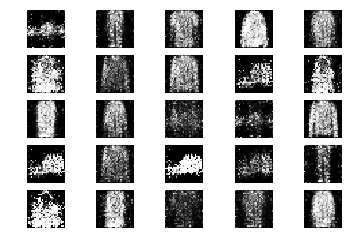

2201 [D loss: 0.621759, acc.: 62.50%] [G loss: 1.315190]
2202 [D loss: 0.679193, acc.: 64.06%] [G loss: 1.206964]
2203 [D loss: 0.722679, acc.: 54.69%] [G loss: 1.333845]
2204 [D loss: 0.608595, acc.: 65.62%] [G loss: 1.194821]
2205 [D loss: 0.653688, acc.: 62.50%] [G loss: 1.294683]
2206 [D loss: 0.622357, acc.: 62.50%] [G loss: 1.113161]
2207 [D loss: 0.599114, acc.: 65.62%] [G loss: 1.054541]
2208 [D loss: 0.553323, acc.: 75.00%] [G loss: 1.008336]
2209 [D loss: 0.508008, acc.: 76.56%] [G loss: 1.200702]
2210 [D loss: 0.738884, acc.: 56.25%] [G loss: 1.557667]
2211 [D loss: 0.658405, acc.: 59.38%] [G loss: 1.530763]
2212 [D loss: 0.557897, acc.: 71.88%] [G loss: 1.392320]
2213 [D loss: 0.624213, acc.: 56.25%] [G loss: 1.281837]
2214 [D loss: 0.561744, acc.: 73.44%] [G loss: 1.130145]
2215 [D loss: 0.503785, acc.: 75.00%] [G loss: 1.334681]
2216 [D loss: 0.603516, acc.: 59.38%] [G loss: 1.203045]
2217 [D loss: 0.519431, acc.: 76.56%] [G loss: 1.355854]
2218 [D loss: 0.574024, acc.: 6

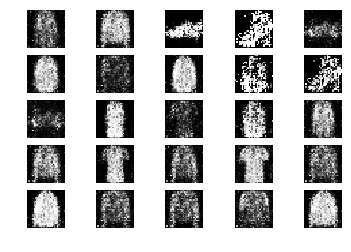

2401 [D loss: 0.541779, acc.: 64.06%] [G loss: 1.080331]
2402 [D loss: 0.473469, acc.: 81.25%] [G loss: 1.137598]
2403 [D loss: 0.627942, acc.: 70.31%] [G loss: 1.129706]
2404 [D loss: 0.553443, acc.: 71.88%] [G loss: 1.065478]
2405 [D loss: 0.567477, acc.: 75.00%] [G loss: 1.026872]
2406 [D loss: 0.609683, acc.: 67.19%] [G loss: 1.019429]
2407 [D loss: 0.520436, acc.: 70.31%] [G loss: 1.213168]
2408 [D loss: 0.613680, acc.: 64.06%] [G loss: 1.140139]
2409 [D loss: 0.576680, acc.: 68.75%] [G loss: 1.071268]
2410 [D loss: 0.641504, acc.: 65.62%] [G loss: 1.026456]
2411 [D loss: 0.562211, acc.: 68.75%] [G loss: 1.183244]
2412 [D loss: 0.680222, acc.: 67.19%] [G loss: 1.021091]
2413 [D loss: 0.638514, acc.: 59.38%] [G loss: 1.058103]
2414 [D loss: 0.721935, acc.: 57.81%] [G loss: 1.086832]
2415 [D loss: 0.552144, acc.: 65.62%] [G loss: 1.053933]
2416 [D loss: 0.594881, acc.: 68.75%] [G loss: 1.118036]
2417 [D loss: 0.570174, acc.: 71.88%] [G loss: 1.059912]
2418 [D loss: 0.618416, acc.: 7

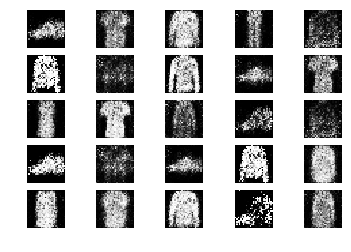

2601 [D loss: 0.517172, acc.: 75.00%] [G loss: 1.047859]
2602 [D loss: 0.536902, acc.: 68.75%] [G loss: 1.111175]
2603 [D loss: 0.605901, acc.: 68.75%] [G loss: 1.141771]
2604 [D loss: 0.535186, acc.: 70.31%] [G loss: 1.160604]
2605 [D loss: 0.615955, acc.: 59.38%] [G loss: 1.038094]
2606 [D loss: 0.548230, acc.: 75.00%] [G loss: 1.066063]
2607 [D loss: 0.536828, acc.: 67.19%] [G loss: 1.004321]
2608 [D loss: 0.562683, acc.: 70.31%] [G loss: 1.087522]
2609 [D loss: 0.643027, acc.: 60.94%] [G loss: 1.054771]
2610 [D loss: 0.536336, acc.: 76.56%] [G loss: 1.186425]
2611 [D loss: 0.498117, acc.: 73.44%] [G loss: 1.376362]
2612 [D loss: 0.611186, acc.: 62.50%] [G loss: 1.250397]
2613 [D loss: 0.602798, acc.: 64.06%] [G loss: 1.223997]
2614 [D loss: 0.566901, acc.: 70.31%] [G loss: 1.139327]
2615 [D loss: 0.645600, acc.: 54.69%] [G loss: 1.110449]
2616 [D loss: 0.613968, acc.: 67.19%] [G loss: 1.251903]
2617 [D loss: 0.746285, acc.: 53.12%] [G loss: 1.186740]
2618 [D loss: 0.557062, acc.: 7

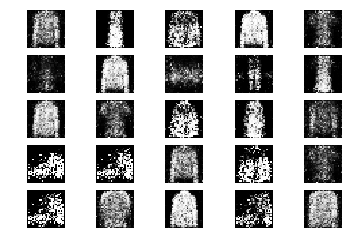

2801 [D loss: 0.569631, acc.: 68.75%] [G loss: 1.237161]
2802 [D loss: 0.661213, acc.: 60.94%] [G loss: 1.184085]
2803 [D loss: 0.553300, acc.: 64.06%] [G loss: 1.217743]
2804 [D loss: 0.533672, acc.: 75.00%] [G loss: 1.216261]
2805 [D loss: 0.571156, acc.: 70.31%] [G loss: 1.167741]
2806 [D loss: 0.605897, acc.: 68.75%] [G loss: 1.221052]
2807 [D loss: 0.652461, acc.: 68.75%] [G loss: 1.111663]
2808 [D loss: 0.586052, acc.: 62.50%] [G loss: 1.206605]
2809 [D loss: 0.649607, acc.: 57.81%] [G loss: 1.193511]
2810 [D loss: 0.533536, acc.: 68.75%] [G loss: 1.231082]
2811 [D loss: 0.541332, acc.: 70.31%] [G loss: 1.209925]
2812 [D loss: 0.631312, acc.: 64.06%] [G loss: 1.088735]
2813 [D loss: 0.595644, acc.: 68.75%] [G loss: 1.108426]
2814 [D loss: 0.590697, acc.: 62.50%] [G loss: 1.121442]
2815 [D loss: 0.670045, acc.: 56.25%] [G loss: 1.065583]
2816 [D loss: 0.566203, acc.: 68.75%] [G loss: 1.224345]
2817 [D loss: 0.540095, acc.: 75.00%] [G loss: 1.080064]
2818 [D loss: 0.563906, acc.: 7

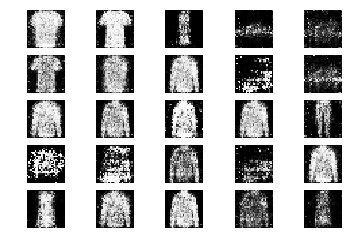

3001 [D loss: 0.605868, acc.: 60.94%] [G loss: 1.378309]
3002 [D loss: 0.602742, acc.: 65.62%] [G loss: 1.058775]
3003 [D loss: 0.600116, acc.: 57.81%] [G loss: 1.077204]
3004 [D loss: 0.682854, acc.: 60.94%] [G loss: 1.077501]
3005 [D loss: 0.623053, acc.: 64.06%] [G loss: 1.169987]
3006 [D loss: 0.509788, acc.: 75.00%] [G loss: 1.243960]
3007 [D loss: 0.550219, acc.: 70.31%] [G loss: 1.282878]
3008 [D loss: 0.623957, acc.: 64.06%] [G loss: 1.353186]
3009 [D loss: 0.514156, acc.: 71.88%] [G loss: 1.203954]
3010 [D loss: 0.606270, acc.: 60.94%] [G loss: 1.255238]
3011 [D loss: 0.532683, acc.: 70.31%] [G loss: 1.258161]
3012 [D loss: 0.555858, acc.: 71.88%] [G loss: 1.176466]
3013 [D loss: 0.455765, acc.: 84.38%] [G loss: 1.115520]
3014 [D loss: 0.553802, acc.: 71.88%] [G loss: 1.358807]
3015 [D loss: 0.590587, acc.: 68.75%] [G loss: 1.289122]
3016 [D loss: 0.597374, acc.: 67.19%] [G loss: 1.410766]
3017 [D loss: 0.537360, acc.: 78.12%] [G loss: 1.282837]
3018 [D loss: 0.638561, acc.: 6

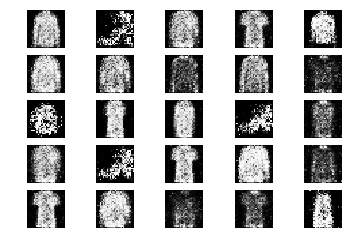

3201 [D loss: 0.543007, acc.: 73.44%] [G loss: 1.140374]
3202 [D loss: 0.442323, acc.: 81.25%] [G loss: 1.345677]
3203 [D loss: 0.562987, acc.: 73.44%] [G loss: 1.122479]
3204 [D loss: 0.555011, acc.: 68.75%] [G loss: 1.202809]
3205 [D loss: 0.475777, acc.: 81.25%] [G loss: 1.187427]
3206 [D loss: 0.598634, acc.: 67.19%] [G loss: 1.030944]
3207 [D loss: 0.635937, acc.: 65.62%] [G loss: 1.179323]
3208 [D loss: 0.621183, acc.: 65.62%] [G loss: 1.101659]
3209 [D loss: 0.516716, acc.: 79.69%] [G loss: 1.015693]
3210 [D loss: 0.559752, acc.: 60.94%] [G loss: 1.089445]
3211 [D loss: 0.537666, acc.: 71.88%] [G loss: 1.369955]
3212 [D loss: 0.556768, acc.: 68.75%] [G loss: 1.239153]
3213 [D loss: 0.618728, acc.: 56.25%] [G loss: 1.080173]
3214 [D loss: 0.558920, acc.: 62.50%] [G loss: 1.118830]
3215 [D loss: 0.608070, acc.: 65.62%] [G loss: 1.140642]
3216 [D loss: 0.551177, acc.: 60.94%] [G loss: 0.973786]
3217 [D loss: 0.516651, acc.: 79.69%] [G loss: 1.052932]
3218 [D loss: 0.517708, acc.: 7

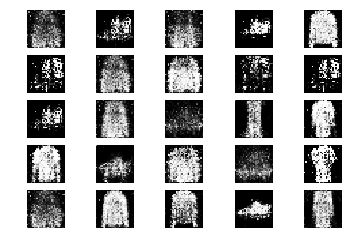

3401 [D loss: 0.579061, acc.: 64.06%] [G loss: 1.243566]
3402 [D loss: 0.496870, acc.: 76.56%] [G loss: 1.178400]
3403 [D loss: 0.509285, acc.: 75.00%] [G loss: 1.265160]
3404 [D loss: 0.632919, acc.: 57.81%] [G loss: 1.104223]
3405 [D loss: 0.629551, acc.: 73.44%] [G loss: 1.107752]
3406 [D loss: 0.631902, acc.: 64.06%] [G loss: 1.132710]
3407 [D loss: 0.567440, acc.: 70.31%] [G loss: 1.131969]
3408 [D loss: 0.588373, acc.: 68.75%] [G loss: 1.153057]
3409 [D loss: 0.563034, acc.: 71.88%] [G loss: 1.104368]
3410 [D loss: 0.646926, acc.: 59.38%] [G loss: 1.044281]
3411 [D loss: 0.642628, acc.: 56.25%] [G loss: 1.155483]
3412 [D loss: 0.621514, acc.: 60.94%] [G loss: 1.051438]
3413 [D loss: 0.633638, acc.: 54.69%] [G loss: 0.977708]
3414 [D loss: 0.502528, acc.: 81.25%] [G loss: 1.147304]
3415 [D loss: 0.523418, acc.: 75.00%] [G loss: 0.998496]
3416 [D loss: 0.586914, acc.: 60.94%] [G loss: 1.072655]
3417 [D loss: 0.607732, acc.: 60.94%] [G loss: 1.279440]
3418 [D loss: 0.602392, acc.: 6

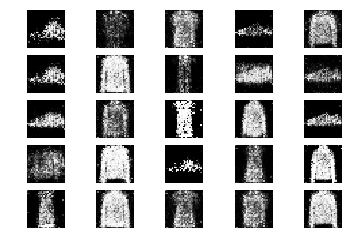

3601 [D loss: 0.627760, acc.: 71.88%] [G loss: 1.073321]
3602 [D loss: 0.600393, acc.: 64.06%] [G loss: 0.974639]
3603 [D loss: 0.525416, acc.: 76.56%] [G loss: 1.003425]
3604 [D loss: 0.606979, acc.: 71.88%] [G loss: 1.095291]
3605 [D loss: 0.512836, acc.: 73.44%] [G loss: 1.239776]
3606 [D loss: 0.625420, acc.: 64.06%] [G loss: 1.094232]
3607 [D loss: 0.594527, acc.: 68.75%] [G loss: 1.035364]
3608 [D loss: 0.681676, acc.: 68.75%] [G loss: 1.071670]
3609 [D loss: 0.662838, acc.: 60.94%] [G loss: 1.174708]
3610 [D loss: 0.570084, acc.: 68.75%] [G loss: 1.058401]
3611 [D loss: 0.554517, acc.: 67.19%] [G loss: 1.011859]
3612 [D loss: 0.691096, acc.: 57.81%] [G loss: 0.977942]
3613 [D loss: 0.638722, acc.: 59.38%] [G loss: 1.043571]
3614 [D loss: 0.579255, acc.: 68.75%] [G loss: 0.988105]
3615 [D loss: 0.572701, acc.: 64.06%] [G loss: 0.999736]
3616 [D loss: 0.637087, acc.: 54.69%] [G loss: 1.014031]
3617 [D loss: 0.628204, acc.: 65.62%] [G loss: 0.959936]
3618 [D loss: 0.593277, acc.: 6

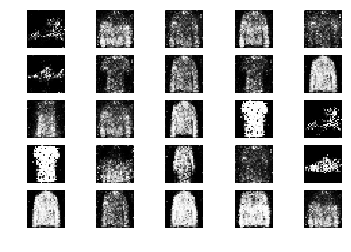

3801 [D loss: 0.552258, acc.: 75.00%] [G loss: 0.991922]
3802 [D loss: 0.567164, acc.: 70.31%] [G loss: 1.011445]
3803 [D loss: 0.588660, acc.: 65.62%] [G loss: 1.045784]
3804 [D loss: 0.564906, acc.: 71.88%] [G loss: 1.015277]
3805 [D loss: 0.596631, acc.: 70.31%] [G loss: 0.943328]
3806 [D loss: 0.574237, acc.: 68.75%] [G loss: 1.062236]
3807 [D loss: 0.636427, acc.: 60.94%] [G loss: 0.979955]
3808 [D loss: 0.574236, acc.: 65.62%] [G loss: 1.014801]
3809 [D loss: 0.613436, acc.: 56.25%] [G loss: 0.970893]
3810 [D loss: 0.610045, acc.: 60.94%] [G loss: 1.062075]
3811 [D loss: 0.569502, acc.: 70.31%] [G loss: 1.014077]
3812 [D loss: 0.611867, acc.: 62.50%] [G loss: 1.105605]
3813 [D loss: 0.654163, acc.: 53.12%] [G loss: 1.004802]
3814 [D loss: 0.536116, acc.: 70.31%] [G loss: 1.071022]
3815 [D loss: 0.625306, acc.: 64.06%] [G loss: 1.009493]
3816 [D loss: 0.654437, acc.: 67.19%] [G loss: 1.092016]
3817 [D loss: 0.575355, acc.: 65.62%] [G loss: 1.043496]
3818 [D loss: 0.604259, acc.: 6

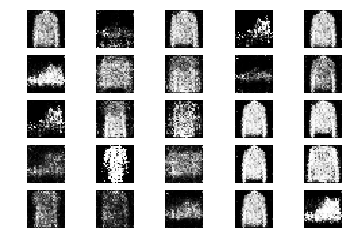

4001 [D loss: 0.624226, acc.: 65.62%] [G loss: 1.052605]
4002 [D loss: 0.850396, acc.: 46.88%] [G loss: 0.962017]
4003 [D loss: 0.652250, acc.: 54.69%] [G loss: 1.089087]
4004 [D loss: 0.685433, acc.: 56.25%] [G loss: 1.026101]
4005 [D loss: 0.489839, acc.: 75.00%] [G loss: 1.007097]
4006 [D loss: 0.705816, acc.: 48.44%] [G loss: 0.953704]
4007 [D loss: 0.593742, acc.: 62.50%] [G loss: 1.051446]
4008 [D loss: 0.685886, acc.: 59.38%] [G loss: 1.026911]
4009 [D loss: 0.682405, acc.: 53.12%] [G loss: 0.892503]
4010 [D loss: 0.633535, acc.: 62.50%] [G loss: 0.951566]
4011 [D loss: 0.671995, acc.: 60.94%] [G loss: 0.931185]
4012 [D loss: 0.581735, acc.: 68.75%] [G loss: 0.950493]
4013 [D loss: 0.641015, acc.: 60.94%] [G loss: 1.089593]
4014 [D loss: 0.566834, acc.: 71.88%] [G loss: 0.990664]
4015 [D loss: 0.648394, acc.: 59.38%] [G loss: 1.002177]
4016 [D loss: 0.683138, acc.: 51.56%] [G loss: 0.972589]
4017 [D loss: 0.630934, acc.: 62.50%] [G loss: 0.990844]
4018 [D loss: 0.583330, acc.: 6

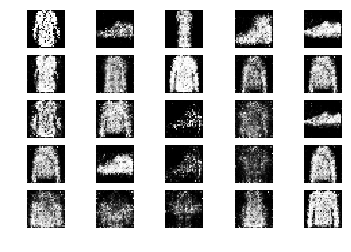

4201 [D loss: 0.658634, acc.: 54.69%] [G loss: 0.916062]
4202 [D loss: 0.708286, acc.: 57.81%] [G loss: 1.010133]
4203 [D loss: 0.610478, acc.: 73.44%] [G loss: 1.010746]
4204 [D loss: 0.615055, acc.: 59.38%] [G loss: 0.912981]
4205 [D loss: 0.655190, acc.: 54.69%] [G loss: 1.005221]
4206 [D loss: 0.687976, acc.: 57.81%] [G loss: 0.935136]
4207 [D loss: 0.675016, acc.: 57.81%] [G loss: 0.967048]
4208 [D loss: 0.609826, acc.: 62.50%] [G loss: 0.906043]
4209 [D loss: 0.584402, acc.: 65.62%] [G loss: 0.907598]
4210 [D loss: 0.627254, acc.: 60.94%] [G loss: 0.929747]
4211 [D loss: 0.616537, acc.: 73.44%] [G loss: 0.919764]
4212 [D loss: 0.612193, acc.: 73.44%] [G loss: 0.963499]
4213 [D loss: 0.679223, acc.: 64.06%] [G loss: 0.891876]
4214 [D loss: 0.677676, acc.: 53.12%] [G loss: 0.900135]
4215 [D loss: 0.575133, acc.: 70.31%] [G loss: 0.925441]
4216 [D loss: 0.601907, acc.: 67.19%] [G loss: 0.993503]
4217 [D loss: 0.669739, acc.: 64.06%] [G loss: 0.991417]
4218 [D loss: 0.579092, acc.: 6

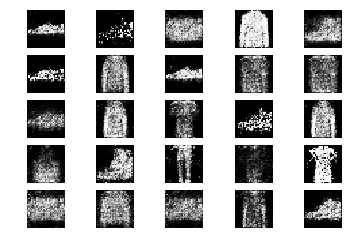

4401 [D loss: 0.603888, acc.: 70.31%] [G loss: 0.881284]
4402 [D loss: 0.604843, acc.: 65.62%] [G loss: 0.831379]
4403 [D loss: 0.582322, acc.: 67.19%] [G loss: 0.928555]
4404 [D loss: 0.651270, acc.: 62.50%] [G loss: 0.930791]
4405 [D loss: 0.571289, acc.: 71.88%] [G loss: 0.931934]
4406 [D loss: 0.667023, acc.: 57.81%] [G loss: 0.929025]
4407 [D loss: 0.664369, acc.: 53.12%] [G loss: 0.911168]
4408 [D loss: 0.630760, acc.: 59.38%] [G loss: 0.892359]
4409 [D loss: 0.620733, acc.: 65.62%] [G loss: 0.888833]
4410 [D loss: 0.685191, acc.: 56.25%] [G loss: 0.920570]
4411 [D loss: 0.641858, acc.: 62.50%] [G loss: 0.905939]
4412 [D loss: 0.664479, acc.: 56.25%] [G loss: 0.969112]
4413 [D loss: 0.703090, acc.: 54.69%] [G loss: 0.916733]
4414 [D loss: 0.623015, acc.: 60.94%] [G loss: 0.936369]
4415 [D loss: 0.594160, acc.: 60.94%] [G loss: 0.935368]
4416 [D loss: 0.679147, acc.: 59.38%] [G loss: 0.958853]
4417 [D loss: 0.620862, acc.: 71.88%] [G loss: 0.933707]
4418 [D loss: 0.569147, acc.: 6

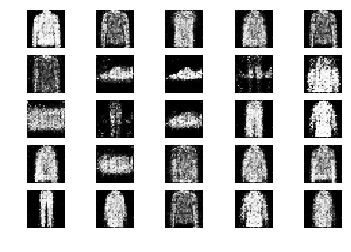

4601 [D loss: 0.634396, acc.: 59.38%] [G loss: 0.837656]
4602 [D loss: 0.724941, acc.: 51.56%] [G loss: 0.816808]
4603 [D loss: 0.618115, acc.: 62.50%] [G loss: 0.852075]
4604 [D loss: 0.644946, acc.: 65.62%] [G loss: 0.912698]
4605 [D loss: 0.687042, acc.: 57.81%] [G loss: 0.821756]
4606 [D loss: 0.615063, acc.: 64.06%] [G loss: 0.903212]
4607 [D loss: 0.600266, acc.: 68.75%] [G loss: 0.870662]
4608 [D loss: 0.677438, acc.: 56.25%] [G loss: 0.898239]
4609 [D loss: 0.629042, acc.: 65.62%] [G loss: 0.875887]
4610 [D loss: 0.669917, acc.: 62.50%] [G loss: 0.930511]
4611 [D loss: 0.742898, acc.: 50.00%] [G loss: 0.833451]
4612 [D loss: 0.629575, acc.: 68.75%] [G loss: 0.874439]
4613 [D loss: 0.662628, acc.: 62.50%] [G loss: 0.885611]
4614 [D loss: 0.686160, acc.: 54.69%] [G loss: 0.879000]
4615 [D loss: 0.703995, acc.: 51.56%] [G loss: 0.936674]
4616 [D loss: 0.626782, acc.: 67.19%] [G loss: 0.888005]
4617 [D loss: 0.591903, acc.: 62.50%] [G loss: 0.888500]
4618 [D loss: 0.574908, acc.: 7

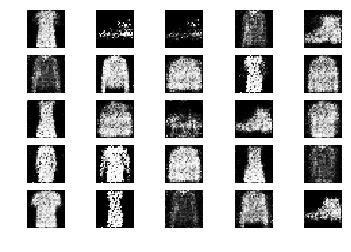

4801 [D loss: 0.610892, acc.: 71.88%] [G loss: 0.839906]
4802 [D loss: 0.687574, acc.: 59.38%] [G loss: 0.797927]
4803 [D loss: 0.643839, acc.: 60.94%] [G loss: 0.838729]
4804 [D loss: 0.612078, acc.: 65.62%] [G loss: 0.863357]
4805 [D loss: 0.677852, acc.: 56.25%] [G loss: 0.893051]
4806 [D loss: 0.685276, acc.: 57.81%] [G loss: 1.022882]
4807 [D loss: 0.662539, acc.: 64.06%] [G loss: 0.838613]
4808 [D loss: 0.663107, acc.: 62.50%] [G loss: 0.940002]
4809 [D loss: 0.672614, acc.: 57.81%] [G loss: 0.971793]
4810 [D loss: 0.664674, acc.: 64.06%] [G loss: 0.846985]
4811 [D loss: 0.636465, acc.: 65.62%] [G loss: 0.860009]
4812 [D loss: 0.657811, acc.: 57.81%] [G loss: 0.894609]
4813 [D loss: 0.643145, acc.: 62.50%] [G loss: 0.845387]
4814 [D loss: 0.635095, acc.: 68.75%] [G loss: 0.934569]
4815 [D loss: 0.743477, acc.: 57.81%] [G loss: 0.917549]
4816 [D loss: 0.657924, acc.: 54.69%] [G loss: 0.844304]
4817 [D loss: 0.654546, acc.: 62.50%] [G loss: 0.870615]
4818 [D loss: 0.660187, acc.: 6

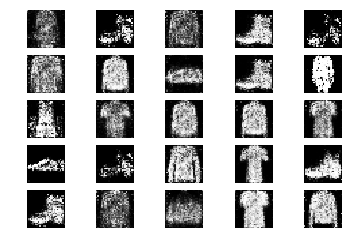

5001 [D loss: 0.632358, acc.: 76.56%] [G loss: 0.903798]
5002 [D loss: 0.691064, acc.: 56.25%] [G loss: 0.798209]
5003 [D loss: 0.637598, acc.: 59.38%] [G loss: 0.814042]
5004 [D loss: 0.661876, acc.: 56.25%] [G loss: 0.916311]
5005 [D loss: 0.586466, acc.: 68.75%] [G loss: 1.010472]
5006 [D loss: 0.706317, acc.: 57.81%] [G loss: 0.928404]
5007 [D loss: 0.626491, acc.: 62.50%] [G loss: 0.899778]
5008 [D loss: 0.668211, acc.: 67.19%] [G loss: 0.869913]
5009 [D loss: 0.646639, acc.: 64.06%] [G loss: 0.916714]
5010 [D loss: 0.644375, acc.: 65.62%] [G loss: 0.952047]
5011 [D loss: 0.690297, acc.: 57.81%] [G loss: 0.950626]
5012 [D loss: 0.648930, acc.: 62.50%] [G loss: 0.900305]
5013 [D loss: 0.666482, acc.: 60.94%] [G loss: 0.886676]
5014 [D loss: 0.629194, acc.: 71.88%] [G loss: 0.873568]
5015 [D loss: 0.705585, acc.: 57.81%] [G loss: 0.888429]
5016 [D loss: 0.623940, acc.: 64.06%] [G loss: 0.842479]
5017 [D loss: 0.668151, acc.: 56.25%] [G loss: 0.903934]
5018 [D loss: 0.639665, acc.: 6

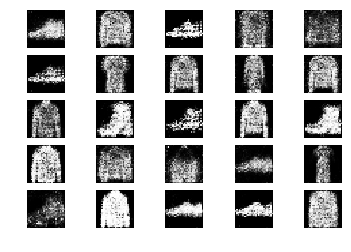

5201 [D loss: 0.626217, acc.: 62.50%] [G loss: 0.869017]
5202 [D loss: 0.662952, acc.: 62.50%] [G loss: 0.947173]
5203 [D loss: 0.645183, acc.: 62.50%] [G loss: 0.911901]
5204 [D loss: 0.655278, acc.: 65.62%] [G loss: 0.905092]
5205 [D loss: 0.667888, acc.: 59.38%] [G loss: 0.865074]
5206 [D loss: 0.613284, acc.: 56.25%] [G loss: 0.894986]
5207 [D loss: 0.631844, acc.: 67.19%] [G loss: 0.897502]
5208 [D loss: 0.621050, acc.: 67.19%] [G loss: 0.927932]
5209 [D loss: 0.690921, acc.: 56.25%] [G loss: 0.896724]
5210 [D loss: 0.612184, acc.: 64.06%] [G loss: 0.881992]
5211 [D loss: 0.594031, acc.: 65.62%] [G loss: 0.874290]
5212 [D loss: 0.634974, acc.: 65.62%] [G loss: 0.959086]
5213 [D loss: 0.616801, acc.: 65.62%] [G loss: 0.860929]
5214 [D loss: 0.647604, acc.: 57.81%] [G loss: 0.889384]
5215 [D loss: 0.596228, acc.: 73.44%] [G loss: 0.862122]
5216 [D loss: 0.707603, acc.: 48.44%] [G loss: 0.907334]
5217 [D loss: 0.647011, acc.: 60.94%] [G loss: 0.933927]
5218 [D loss: 0.635595, acc.: 6

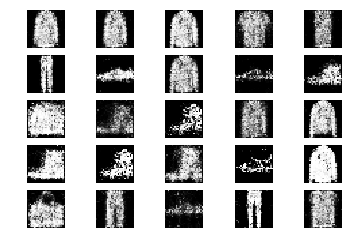

5401 [D loss: 0.641479, acc.: 64.06%] [G loss: 0.862798]
5402 [D loss: 0.629300, acc.: 57.81%] [G loss: 0.845136]
5403 [D loss: 0.695840, acc.: 57.81%] [G loss: 0.810409]
5404 [D loss: 0.657421, acc.: 62.50%] [G loss: 0.846964]
5405 [D loss: 0.639297, acc.: 65.62%] [G loss: 0.861167]
5406 [D loss: 0.614046, acc.: 65.62%] [G loss: 0.986858]
5407 [D loss: 0.583470, acc.: 73.44%] [G loss: 0.817173]
5408 [D loss: 0.632499, acc.: 64.06%] [G loss: 0.964832]
5409 [D loss: 0.632855, acc.: 56.25%] [G loss: 0.894045]
5410 [D loss: 0.659485, acc.: 68.75%] [G loss: 0.999603]
5411 [D loss: 0.672826, acc.: 56.25%] [G loss: 0.864447]
5412 [D loss: 0.643582, acc.: 62.50%] [G loss: 0.882918]
5413 [D loss: 0.677784, acc.: 54.69%] [G loss: 0.865008]
5414 [D loss: 0.693592, acc.: 48.44%] [G loss: 0.937085]
5415 [D loss: 0.695298, acc.: 53.12%] [G loss: 0.839587]
5416 [D loss: 0.677465, acc.: 54.69%] [G loss: 0.925635]
5417 [D loss: 0.713121, acc.: 56.25%] [G loss: 0.910177]
5418 [D loss: 0.632305, acc.: 6

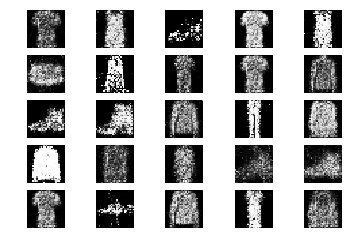

5601 [D loss: 0.685116, acc.: 50.00%] [G loss: 0.855493]
5602 [D loss: 0.612332, acc.: 70.31%] [G loss: 0.822948]
5603 [D loss: 0.644102, acc.: 56.25%] [G loss: 0.843260]
5604 [D loss: 0.619006, acc.: 62.50%] [G loss: 0.863683]
5605 [D loss: 0.645849, acc.: 67.19%] [G loss: 0.867839]
5606 [D loss: 0.666309, acc.: 54.69%] [G loss: 0.923876]
5607 [D loss: 0.632116, acc.: 64.06%] [G loss: 0.852429]
5608 [D loss: 0.651705, acc.: 64.06%] [G loss: 0.916655]
5609 [D loss: 0.664544, acc.: 59.38%] [G loss: 0.978663]
5610 [D loss: 0.664701, acc.: 57.81%] [G loss: 0.997583]
5611 [D loss: 0.607578, acc.: 71.88%] [G loss: 0.950498]
5612 [D loss: 0.633758, acc.: 65.62%] [G loss: 0.976626]
5613 [D loss: 0.664371, acc.: 64.06%] [G loss: 0.976023]
5614 [D loss: 0.706847, acc.: 54.69%] [G loss: 0.922299]
5615 [D loss: 0.626531, acc.: 60.94%] [G loss: 1.022393]
5616 [D loss: 0.696991, acc.: 54.69%] [G loss: 0.969556]
5617 [D loss: 0.732472, acc.: 53.12%] [G loss: 0.893558]
5618 [D loss: 0.637314, acc.: 6

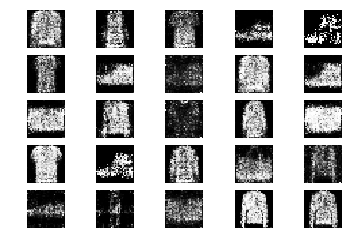

5801 [D loss: 0.602695, acc.: 71.88%] [G loss: 0.936873]
5802 [D loss: 0.645031, acc.: 59.38%] [G loss: 0.979046]
5803 [D loss: 0.724662, acc.: 53.12%] [G loss: 0.948101]
5804 [D loss: 0.624375, acc.: 65.62%] [G loss: 0.914309]
5805 [D loss: 0.687721, acc.: 54.69%] [G loss: 0.962150]
5806 [D loss: 0.640272, acc.: 64.06%] [G loss: 0.932815]
5807 [D loss: 0.607554, acc.: 68.75%] [G loss: 0.914797]
5808 [D loss: 0.602103, acc.: 68.75%] [G loss: 0.975599]
5809 [D loss: 0.642995, acc.: 68.75%] [G loss: 0.923932]
5810 [D loss: 0.630773, acc.: 60.94%] [G loss: 0.970579]
5811 [D loss: 0.659111, acc.: 64.06%] [G loss: 0.981987]
5812 [D loss: 0.609094, acc.: 75.00%] [G loss: 0.990755]
5813 [D loss: 0.570361, acc.: 75.00%] [G loss: 1.043979]
5814 [D loss: 0.640142, acc.: 62.50%] [G loss: 0.904397]
5815 [D loss: 0.626310, acc.: 67.19%] [G loss: 0.953641]
5816 [D loss: 0.582497, acc.: 70.31%] [G loss: 0.881212]
5817 [D loss: 0.714473, acc.: 48.44%] [G loss: 0.933798]
5818 [D loss: 0.585040, acc.: 7

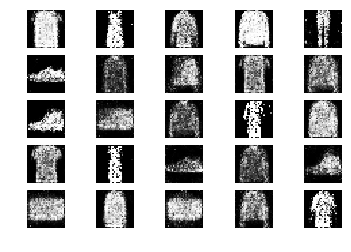

6001 [D loss: 0.598862, acc.: 71.88%] [G loss: 0.898514]
6002 [D loss: 0.656513, acc.: 59.38%] [G loss: 0.957491]
6003 [D loss: 0.619251, acc.: 59.38%] [G loss: 0.899335]
6004 [D loss: 0.573987, acc.: 78.12%] [G loss: 0.852815]
6005 [D loss: 0.752870, acc.: 45.31%] [G loss: 0.880379]
6006 [D loss: 0.649816, acc.: 64.06%] [G loss: 0.884716]
6007 [D loss: 0.622415, acc.: 67.19%] [G loss: 0.878330]
6008 [D loss: 0.633948, acc.: 60.94%] [G loss: 0.886239]
6009 [D loss: 0.680785, acc.: 53.12%] [G loss: 0.885575]
6010 [D loss: 0.569005, acc.: 70.31%] [G loss: 0.918204]
6011 [D loss: 0.687412, acc.: 57.81%] [G loss: 0.969074]
6012 [D loss: 0.624784, acc.: 67.19%] [G loss: 0.883983]
6013 [D loss: 0.592999, acc.: 71.88%] [G loss: 0.978006]
6014 [D loss: 0.609172, acc.: 78.12%] [G loss: 0.940099]
6015 [D loss: 0.570541, acc.: 73.44%] [G loss: 0.922611]
6016 [D loss: 0.633151, acc.: 67.19%] [G loss: 1.042160]
6017 [D loss: 0.632756, acc.: 65.62%] [G loss: 0.984513]
6018 [D loss: 0.762737, acc.: 4

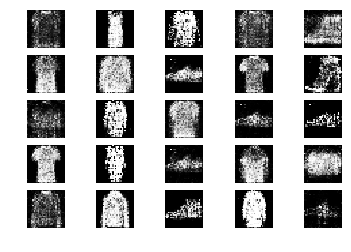

6201 [D loss: 0.661061, acc.: 56.25%] [G loss: 0.948760]
6202 [D loss: 0.626947, acc.: 59.38%] [G loss: 0.917708]
6203 [D loss: 0.703158, acc.: 59.38%] [G loss: 1.021556]
6204 [D loss: 0.603273, acc.: 60.94%] [G loss: 0.940964]
6205 [D loss: 0.589453, acc.: 70.31%] [G loss: 0.895191]
6206 [D loss: 0.616778, acc.: 62.50%] [G loss: 0.893150]
6207 [D loss: 0.658822, acc.: 62.50%] [G loss: 0.889238]
6208 [D loss: 0.634726, acc.: 57.81%] [G loss: 0.914759]
6209 [D loss: 0.599226, acc.: 67.19%] [G loss: 0.814676]
6210 [D loss: 0.669189, acc.: 54.69%] [G loss: 0.858004]
6211 [D loss: 0.652853, acc.: 62.50%] [G loss: 0.858687]
6212 [D loss: 0.637286, acc.: 70.31%] [G loss: 0.861748]
6213 [D loss: 0.696431, acc.: 62.50%] [G loss: 0.918775]
6214 [D loss: 0.663582, acc.: 57.81%] [G loss: 0.946434]
6215 [D loss: 0.698249, acc.: 53.12%] [G loss: 1.028940]
6216 [D loss: 0.667047, acc.: 59.38%] [G loss: 0.971722]
6217 [D loss: 0.668867, acc.: 60.94%] [G loss: 0.886518]
6218 [D loss: 0.637960, acc.: 6

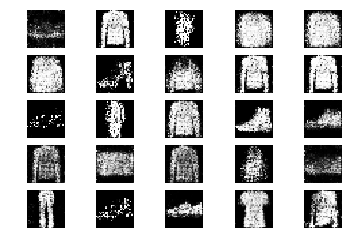

6401 [D loss: 0.685356, acc.: 50.00%] [G loss: 0.983912]
6402 [D loss: 0.588474, acc.: 70.31%] [G loss: 0.980820]
6403 [D loss: 0.629845, acc.: 65.62%] [G loss: 0.886121]
6404 [D loss: 0.743401, acc.: 60.94%] [G loss: 0.901343]
6405 [D loss: 0.652689, acc.: 60.94%] [G loss: 1.037630]
6406 [D loss: 0.648474, acc.: 59.38%] [G loss: 1.076971]
6407 [D loss: 0.672851, acc.: 62.50%] [G loss: 0.945267]
6408 [D loss: 0.688736, acc.: 53.12%] [G loss: 0.884384]
6409 [D loss: 0.649942, acc.: 60.94%] [G loss: 0.899442]
6410 [D loss: 0.648297, acc.: 65.62%] [G loss: 0.929217]
6411 [D loss: 0.695539, acc.: 50.00%] [G loss: 0.993909]
6412 [D loss: 0.625856, acc.: 68.75%] [G loss: 0.948524]
6413 [D loss: 0.700202, acc.: 51.56%] [G loss: 0.980459]
6414 [D loss: 0.645694, acc.: 53.12%] [G loss: 0.934633]
6415 [D loss: 0.659279, acc.: 56.25%] [G loss: 0.975395]
6416 [D loss: 0.699716, acc.: 56.25%] [G loss: 0.969248]
6417 [D loss: 0.649002, acc.: 62.50%] [G loss: 0.921574]
6418 [D loss: 0.590906, acc.: 6

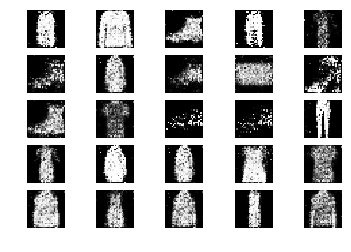

6601 [D loss: 0.642902, acc.: 59.38%] [G loss: 0.975969]
6602 [D loss: 0.671869, acc.: 56.25%] [G loss: 0.871492]
6603 [D loss: 0.688307, acc.: 62.50%] [G loss: 0.863949]
6604 [D loss: 0.619128, acc.: 68.75%] [G loss: 0.930681]
6605 [D loss: 0.656011, acc.: 57.81%] [G loss: 0.961202]
6606 [D loss: 0.680873, acc.: 57.81%] [G loss: 0.977139]
6607 [D loss: 0.686186, acc.: 57.81%] [G loss: 0.945219]
6608 [D loss: 0.639134, acc.: 60.94%] [G loss: 0.883167]
6609 [D loss: 0.688095, acc.: 65.62%] [G loss: 0.879796]
6610 [D loss: 0.636540, acc.: 64.06%] [G loss: 0.869538]
6611 [D loss: 0.630803, acc.: 62.50%] [G loss: 0.910130]
6612 [D loss: 0.670994, acc.: 59.38%] [G loss: 0.943170]
6613 [D loss: 0.678486, acc.: 59.38%] [G loss: 0.989732]
6614 [D loss: 0.609129, acc.: 65.62%] [G loss: 0.970912]
6615 [D loss: 0.746468, acc.: 42.19%] [G loss: 0.846899]
6616 [D loss: 0.779038, acc.: 43.75%] [G loss: 0.930189]
6617 [D loss: 0.597673, acc.: 71.88%] [G loss: 0.869898]
6618 [D loss: 0.626926, acc.: 6

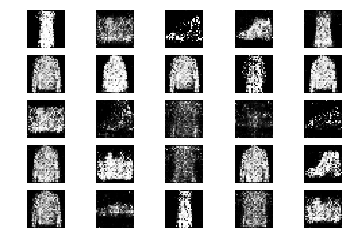

6801 [D loss: 0.633205, acc.: 65.62%] [G loss: 1.087297]
6802 [D loss: 0.597160, acc.: 78.12%] [G loss: 1.078330]
6803 [D loss: 0.552662, acc.: 75.00%] [G loss: 1.051933]
6804 [D loss: 0.634934, acc.: 67.19%] [G loss: 0.970157]
6805 [D loss: 0.598260, acc.: 68.75%] [G loss: 1.016371]
6806 [D loss: 0.586926, acc.: 75.00%] [G loss: 0.968120]
6807 [D loss: 0.578755, acc.: 75.00%] [G loss: 0.946097]
6808 [D loss: 0.597824, acc.: 70.31%] [G loss: 1.014175]
6809 [D loss: 0.651890, acc.: 67.19%] [G loss: 1.058162]
6810 [D loss: 0.631276, acc.: 60.94%] [G loss: 1.001375]
6811 [D loss: 0.633819, acc.: 64.06%] [G loss: 0.971932]
6812 [D loss: 0.619262, acc.: 60.94%] [G loss: 0.878027]
6813 [D loss: 0.659187, acc.: 64.06%] [G loss: 0.919007]
6814 [D loss: 0.596378, acc.: 65.62%] [G loss: 1.007807]
6815 [D loss: 0.595454, acc.: 65.62%] [G loss: 0.977211]
6816 [D loss: 0.735443, acc.: 48.44%] [G loss: 1.030742]
6817 [D loss: 0.666309, acc.: 54.69%] [G loss: 1.036074]
6818 [D loss: 0.655102, acc.: 6

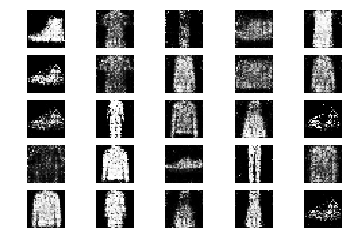

7001 [D loss: 0.601521, acc.: 62.50%] [G loss: 1.005129]
7002 [D loss: 0.612410, acc.: 67.19%] [G loss: 0.993701]
7003 [D loss: 0.667651, acc.: 57.81%] [G loss: 0.975511]
7004 [D loss: 0.636723, acc.: 60.94%] [G loss: 1.070626]
7005 [D loss: 0.634259, acc.: 62.50%] [G loss: 0.990490]
7006 [D loss: 0.641398, acc.: 60.94%] [G loss: 0.928511]
7007 [D loss: 0.637608, acc.: 65.62%] [G loss: 0.946210]
7008 [D loss: 0.652491, acc.: 57.81%] [G loss: 0.893602]
7009 [D loss: 0.626608, acc.: 62.50%] [G loss: 1.084661]
7010 [D loss: 0.670475, acc.: 59.38%] [G loss: 1.092611]
7011 [D loss: 0.681506, acc.: 62.50%] [G loss: 1.007103]
7012 [D loss: 0.706266, acc.: 64.06%] [G loss: 0.981200]
7013 [D loss: 0.640677, acc.: 57.81%] [G loss: 0.988322]
7014 [D loss: 0.686068, acc.: 57.81%] [G loss: 0.994982]
7015 [D loss: 0.575451, acc.: 76.56%] [G loss: 0.941021]
7016 [D loss: 0.640073, acc.: 67.19%] [G loss: 0.985063]
7017 [D loss: 0.655456, acc.: 51.56%] [G loss: 0.985895]
7018 [D loss: 0.658456, acc.: 6

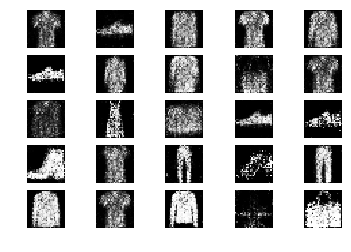

7201 [D loss: 0.610462, acc.: 75.00%] [G loss: 0.959539]
7202 [D loss: 0.618731, acc.: 60.94%] [G loss: 0.953155]
7203 [D loss: 0.656270, acc.: 62.50%] [G loss: 0.930775]
7204 [D loss: 0.635198, acc.: 64.06%] [G loss: 0.905776]
7205 [D loss: 0.653583, acc.: 53.12%] [G loss: 0.943338]
7206 [D loss: 0.637193, acc.: 64.06%] [G loss: 0.912507]
7207 [D loss: 0.716965, acc.: 54.69%] [G loss: 0.926447]
7208 [D loss: 0.667949, acc.: 56.25%] [G loss: 0.912512]
7209 [D loss: 0.726183, acc.: 54.69%] [G loss: 0.996589]
7210 [D loss: 0.678780, acc.: 54.69%] [G loss: 0.959337]
7211 [D loss: 0.569309, acc.: 71.88%] [G loss: 0.861481]
7212 [D loss: 0.639988, acc.: 68.75%] [G loss: 0.890913]
7213 [D loss: 0.664971, acc.: 54.69%] [G loss: 0.971613]
7214 [D loss: 0.590446, acc.: 65.62%] [G loss: 0.899482]
7215 [D loss: 0.618650, acc.: 70.31%] [G loss: 0.933967]
7216 [D loss: 0.678451, acc.: 59.38%] [G loss: 0.998345]
7217 [D loss: 0.620783, acc.: 71.88%] [G loss: 0.891444]
7218 [D loss: 0.592651, acc.: 7

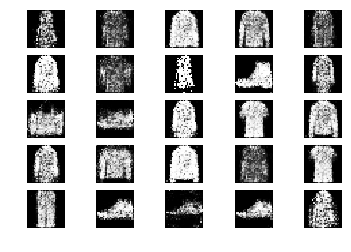

7401 [D loss: 0.635625, acc.: 60.94%] [G loss: 0.915572]
7402 [D loss: 0.684223, acc.: 60.94%] [G loss: 0.933601]
7403 [D loss: 0.633751, acc.: 62.50%] [G loss: 0.878754]
7404 [D loss: 0.648787, acc.: 60.94%] [G loss: 0.920552]
7405 [D loss: 0.735495, acc.: 43.75%] [G loss: 0.911926]
7406 [D loss: 0.696292, acc.: 56.25%] [G loss: 0.944006]
7407 [D loss: 0.634898, acc.: 62.50%] [G loss: 0.938737]
7408 [D loss: 0.618662, acc.: 62.50%] [G loss: 0.924134]
7409 [D loss: 0.703484, acc.: 54.69%] [G loss: 0.889049]
7410 [D loss: 0.677392, acc.: 53.12%] [G loss: 0.938690]
7411 [D loss: 0.639380, acc.: 59.38%] [G loss: 0.891639]
7412 [D loss: 0.610906, acc.: 62.50%] [G loss: 0.901097]
7413 [D loss: 0.674977, acc.: 54.69%] [G loss: 0.918150]
7414 [D loss: 0.642716, acc.: 67.19%] [G loss: 0.895830]
7415 [D loss: 0.634374, acc.: 62.50%] [G loss: 1.017925]
7416 [D loss: 0.671594, acc.: 60.94%] [G loss: 0.994728]
7417 [D loss: 0.655268, acc.: 60.94%] [G loss: 0.928530]
7418 [D loss: 0.666147, acc.: 5

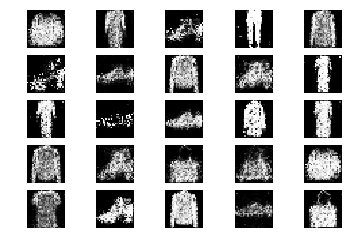

7601 [D loss: 0.590234, acc.: 71.88%] [G loss: 0.905963]
7602 [D loss: 0.627569, acc.: 56.25%] [G loss: 0.959747]
7603 [D loss: 0.632917, acc.: 62.50%] [G loss: 0.950963]
7604 [D loss: 0.719361, acc.: 48.44%] [G loss: 0.969527]
7605 [D loss: 0.585419, acc.: 60.94%] [G loss: 1.104477]
7606 [D loss: 0.650652, acc.: 64.06%] [G loss: 1.036395]
7607 [D loss: 0.612090, acc.: 68.75%] [G loss: 1.132059]
7608 [D loss: 0.663819, acc.: 60.94%] [G loss: 1.002211]
7609 [D loss: 0.662848, acc.: 56.25%] [G loss: 1.011222]
7610 [D loss: 0.630495, acc.: 62.50%] [G loss: 1.046656]
7611 [D loss: 0.679891, acc.: 60.94%] [G loss: 0.941220]
7612 [D loss: 0.642005, acc.: 65.62%] [G loss: 0.971898]
7613 [D loss: 0.710389, acc.: 50.00%] [G loss: 1.057625]
7614 [D loss: 0.624141, acc.: 57.81%] [G loss: 1.004179]
7615 [D loss: 0.678770, acc.: 50.00%] [G loss: 0.943595]
7616 [D loss: 0.621250, acc.: 60.94%] [G loss: 0.901721]
7617 [D loss: 0.680804, acc.: 59.38%] [G loss: 0.960822]
7618 [D loss: 0.630606, acc.: 6

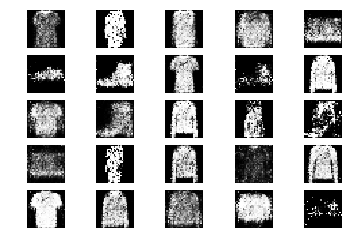

7801 [D loss: 0.657522, acc.: 60.94%] [G loss: 0.954878]
7802 [D loss: 0.651719, acc.: 59.38%] [G loss: 0.900675]
7803 [D loss: 0.618987, acc.: 62.50%] [G loss: 0.993877]
7804 [D loss: 0.634638, acc.: 62.50%] [G loss: 0.891151]
7805 [D loss: 0.651342, acc.: 56.25%] [G loss: 0.970019]
7806 [D loss: 0.665753, acc.: 53.12%] [G loss: 1.006757]
7807 [D loss: 0.638857, acc.: 68.75%] [G loss: 0.935363]
7808 [D loss: 0.583921, acc.: 75.00%] [G loss: 0.948229]
7809 [D loss: 0.621582, acc.: 70.31%] [G loss: 0.903374]
7810 [D loss: 0.585165, acc.: 62.50%] [G loss: 0.923133]
7811 [D loss: 0.703513, acc.: 54.69%] [G loss: 0.939754]
7812 [D loss: 0.594952, acc.: 71.88%] [G loss: 0.962806]
7813 [D loss: 0.668812, acc.: 57.81%] [G loss: 1.056894]
7814 [D loss: 0.709799, acc.: 48.44%] [G loss: 1.128958]
7815 [D loss: 0.557766, acc.: 70.31%] [G loss: 0.997208]
7816 [D loss: 0.616721, acc.: 68.75%] [G loss: 0.890347]
7817 [D loss: 0.693598, acc.: 56.25%] [G loss: 0.893262]
7818 [D loss: 0.624767, acc.: 7

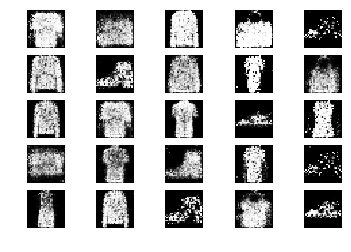

8001 [D loss: 0.718218, acc.: 46.88%] [G loss: 0.804406]
8002 [D loss: 0.714771, acc.: 48.44%] [G loss: 0.845830]
8003 [D loss: 0.646129, acc.: 60.94%] [G loss: 0.985565]
8004 [D loss: 0.619094, acc.: 65.62%] [G loss: 0.940570]
8005 [D loss: 0.678676, acc.: 57.81%] [G loss: 1.079352]
8006 [D loss: 0.648925, acc.: 59.38%] [G loss: 0.924309]
8007 [D loss: 0.626397, acc.: 70.31%] [G loss: 0.896966]
8008 [D loss: 0.655774, acc.: 57.81%] [G loss: 0.899530]
8009 [D loss: 0.678967, acc.: 56.25%] [G loss: 0.893492]
8010 [D loss: 0.727361, acc.: 53.12%] [G loss: 0.857794]
8011 [D loss: 0.638334, acc.: 62.50%] [G loss: 0.917352]
8012 [D loss: 0.656909, acc.: 64.06%] [G loss: 0.948746]
8013 [D loss: 0.683847, acc.: 53.12%] [G loss: 0.876252]
8014 [D loss: 0.677267, acc.: 60.94%] [G loss: 0.935911]
8015 [D loss: 0.664863, acc.: 57.81%] [G loss: 0.874287]
8016 [D loss: 0.638874, acc.: 62.50%] [G loss: 0.902752]
8017 [D loss: 0.654978, acc.: 62.50%] [G loss: 0.857786]
8018 [D loss: 0.609451, acc.: 6

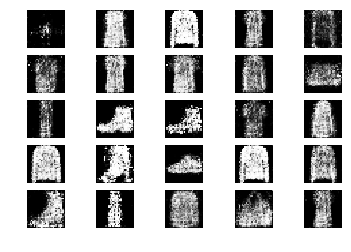

8201 [D loss: 0.661074, acc.: 50.00%] [G loss: 0.815631]
8202 [D loss: 0.643261, acc.: 67.19%] [G loss: 0.924119]
8203 [D loss: 0.653999, acc.: 64.06%] [G loss: 1.039250]
8204 [D loss: 0.687869, acc.: 57.81%] [G loss: 0.959581]
8205 [D loss: 0.652965, acc.: 64.06%] [G loss: 0.924153]
8206 [D loss: 0.634045, acc.: 60.94%] [G loss: 0.899672]
8207 [D loss: 0.599667, acc.: 71.88%] [G loss: 1.027713]
8208 [D loss: 0.678466, acc.: 59.38%] [G loss: 0.980694]
8209 [D loss: 0.649774, acc.: 54.69%] [G loss: 1.015024]
8210 [D loss: 0.637514, acc.: 54.69%] [G loss: 0.979700]
8211 [D loss: 0.615884, acc.: 60.94%] [G loss: 1.028020]
8212 [D loss: 0.683143, acc.: 59.38%] [G loss: 1.065319]
8213 [D loss: 0.652950, acc.: 54.69%] [G loss: 0.966119]
8214 [D loss: 0.669591, acc.: 60.94%] [G loss: 1.014238]
8215 [D loss: 0.572455, acc.: 68.75%] [G loss: 0.970531]
8216 [D loss: 0.643270, acc.: 62.50%] [G loss: 0.951579]
8217 [D loss: 0.574567, acc.: 70.31%] [G loss: 1.064447]
8218 [D loss: 0.643542, acc.: 6

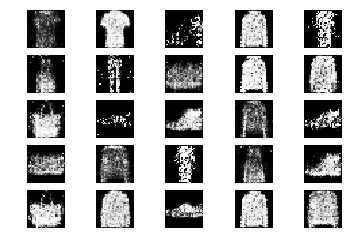

8401 [D loss: 0.660192, acc.: 65.62%] [G loss: 1.047250]
8402 [D loss: 0.661419, acc.: 62.50%] [G loss: 0.903929]
8403 [D loss: 0.678598, acc.: 57.81%] [G loss: 1.058242]
8404 [D loss: 0.652996, acc.: 59.38%] [G loss: 1.006732]
8405 [D loss: 0.666615, acc.: 59.38%] [G loss: 1.061530]
8406 [D loss: 0.588044, acc.: 70.31%] [G loss: 0.936442]
8407 [D loss: 0.650053, acc.: 68.75%] [G loss: 0.924535]
8408 [D loss: 0.660526, acc.: 57.81%] [G loss: 0.925915]
8409 [D loss: 0.660381, acc.: 64.06%] [G loss: 0.911585]
8410 [D loss: 0.586823, acc.: 75.00%] [G loss: 0.981143]
8411 [D loss: 0.695633, acc.: 56.25%] [G loss: 0.984793]
8412 [D loss: 0.662749, acc.: 57.81%] [G loss: 1.006372]
8413 [D loss: 0.549955, acc.: 71.88%] [G loss: 0.972330]
8414 [D loss: 0.629574, acc.: 65.62%] [G loss: 0.932747]
8415 [D loss: 0.650916, acc.: 59.38%] [G loss: 1.000337]
8416 [D loss: 0.621097, acc.: 67.19%] [G loss: 1.112343]
8417 [D loss: 0.658520, acc.: 60.94%] [G loss: 1.045105]
8418 [D loss: 0.652747, acc.: 6

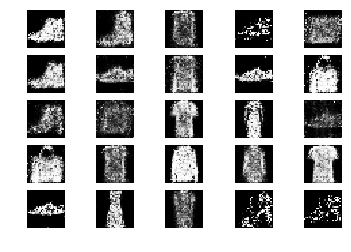

8601 [D loss: 0.605248, acc.: 65.62%] [G loss: 1.008891]
8602 [D loss: 0.695644, acc.: 56.25%] [G loss: 0.931133]
8603 [D loss: 0.606397, acc.: 68.75%] [G loss: 0.926993]
8604 [D loss: 0.578811, acc.: 76.56%] [G loss: 0.900255]
8605 [D loss: 0.606877, acc.: 71.88%] [G loss: 0.827386]
8606 [D loss: 0.727272, acc.: 60.94%] [G loss: 0.952674]
8607 [D loss: 0.619476, acc.: 60.94%] [G loss: 0.974470]
8608 [D loss: 0.644392, acc.: 56.25%] [G loss: 0.915229]
8609 [D loss: 0.655583, acc.: 62.50%] [G loss: 0.983350]
8610 [D loss: 0.684307, acc.: 56.25%] [G loss: 0.849310]
8611 [D loss: 0.614650, acc.: 67.19%] [G loss: 0.785670]
8612 [D loss: 0.667118, acc.: 62.50%] [G loss: 0.879560]
8613 [D loss: 0.708571, acc.: 56.25%] [G loss: 0.906588]
8614 [D loss: 0.618185, acc.: 68.75%] [G loss: 0.998278]
8615 [D loss: 0.616523, acc.: 70.31%] [G loss: 0.923140]
8616 [D loss: 0.625090, acc.: 67.19%] [G loss: 0.918610]
8617 [D loss: 0.616136, acc.: 65.62%] [G loss: 0.902385]
8618 [D loss: 0.575850, acc.: 7

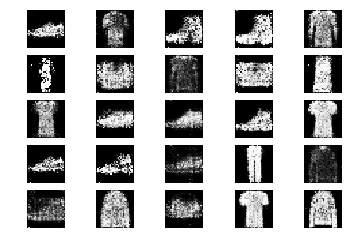

8801 [D loss: 0.653432, acc.: 62.50%] [G loss: 0.947205]
8802 [D loss: 0.676268, acc.: 59.38%] [G loss: 0.894797]
8803 [D loss: 0.549857, acc.: 73.44%] [G loss: 0.884554]
8804 [D loss: 0.576375, acc.: 76.56%] [G loss: 0.919320]
8805 [D loss: 0.632868, acc.: 64.06%] [G loss: 0.868397]
8806 [D loss: 0.667463, acc.: 59.38%] [G loss: 1.007683]
8807 [D loss: 0.576387, acc.: 70.31%] [G loss: 0.921773]
8808 [D loss: 0.682774, acc.: 54.69%] [G loss: 0.857478]
8809 [D loss: 0.636032, acc.: 64.06%] [G loss: 0.869969]
8810 [D loss: 0.636351, acc.: 57.81%] [G loss: 0.888366]
8811 [D loss: 0.646608, acc.: 68.75%] [G loss: 0.948354]
8812 [D loss: 0.674681, acc.: 54.69%] [G loss: 0.906494]
8813 [D loss: 0.715657, acc.: 50.00%] [G loss: 0.909163]
8814 [D loss: 0.701747, acc.: 59.38%] [G loss: 0.879021]
8815 [D loss: 0.686244, acc.: 57.81%] [G loss: 0.816788]
8816 [D loss: 0.632006, acc.: 64.06%] [G loss: 0.874594]
8817 [D loss: 0.657874, acc.: 59.38%] [G loss: 0.785276]
8818 [D loss: 0.642991, acc.: 6

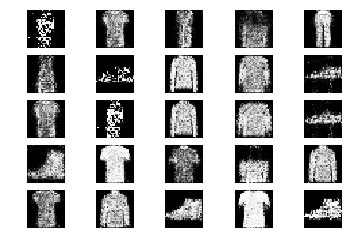

9001 [D loss: 0.634305, acc.: 65.62%] [G loss: 0.898947]
9002 [D loss: 0.671252, acc.: 59.38%] [G loss: 0.866984]
9003 [D loss: 0.599324, acc.: 71.88%] [G loss: 0.868960]
9004 [D loss: 0.691272, acc.: 45.31%] [G loss: 0.972335]
9005 [D loss: 0.625504, acc.: 60.94%] [G loss: 0.976213]
9006 [D loss: 0.654879, acc.: 65.62%] [G loss: 0.972618]
9007 [D loss: 0.698232, acc.: 53.12%] [G loss: 0.901952]
9008 [D loss: 0.608176, acc.: 64.06%] [G loss: 0.930253]
9009 [D loss: 0.714015, acc.: 43.75%] [G loss: 0.900021]
9010 [D loss: 0.664091, acc.: 62.50%] [G loss: 0.949287]
9011 [D loss: 0.655912, acc.: 57.81%] [G loss: 0.899074]
9012 [D loss: 0.633047, acc.: 60.94%] [G loss: 0.919059]
9013 [D loss: 0.634249, acc.: 60.94%] [G loss: 1.023687]
9014 [D loss: 0.676430, acc.: 57.81%] [G loss: 0.906909]
9015 [D loss: 0.641880, acc.: 64.06%] [G loss: 0.908640]
9016 [D loss: 0.675804, acc.: 62.50%] [G loss: 0.923026]
9017 [D loss: 0.672607, acc.: 59.38%] [G loss: 0.949000]
9018 [D loss: 0.676557, acc.: 5

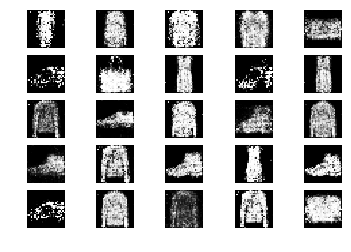

9201 [D loss: 0.635659, acc.: 60.94%] [G loss: 0.985851]
9202 [D loss: 0.624252, acc.: 64.06%] [G loss: 0.975878]
9203 [D loss: 0.577665, acc.: 71.88%] [G loss: 0.988908]
9204 [D loss: 0.558872, acc.: 76.56%] [G loss: 1.021898]
9205 [D loss: 0.624642, acc.: 60.94%] [G loss: 0.999700]
9206 [D loss: 0.666410, acc.: 62.50%] [G loss: 0.872094]
9207 [D loss: 0.584222, acc.: 70.31%] [G loss: 0.984438]
9208 [D loss: 0.652848, acc.: 53.12%] [G loss: 0.896303]
9209 [D loss: 0.630431, acc.: 60.94%] [G loss: 0.901209]
9210 [D loss: 0.637587, acc.: 57.81%] [G loss: 0.911936]
9211 [D loss: 0.632969, acc.: 65.62%] [G loss: 0.938244]
9212 [D loss: 0.624819, acc.: 65.62%] [G loss: 0.950691]
9213 [D loss: 0.651586, acc.: 62.50%] [G loss: 0.991865]
9214 [D loss: 0.651796, acc.: 56.25%] [G loss: 0.893906]
9215 [D loss: 0.624351, acc.: 62.50%] [G loss: 0.942634]
9216 [D loss: 0.634571, acc.: 60.94%] [G loss: 0.900794]
9217 [D loss: 0.772299, acc.: 56.25%] [G loss: 0.877236]
9218 [D loss: 0.649330, acc.: 5

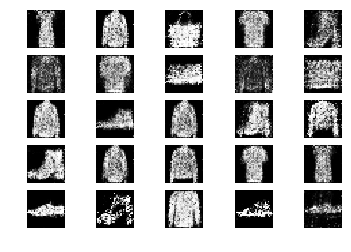

9401 [D loss: 0.609234, acc.: 71.88%] [G loss: 0.958853]
9402 [D loss: 0.597939, acc.: 67.19%] [G loss: 0.889363]
9403 [D loss: 0.611771, acc.: 60.94%] [G loss: 0.920860]
9404 [D loss: 0.709994, acc.: 56.25%] [G loss: 0.870526]
9405 [D loss: 0.704604, acc.: 56.25%] [G loss: 0.943916]
9406 [D loss: 0.651187, acc.: 59.38%] [G loss: 1.032301]
9407 [D loss: 0.645021, acc.: 57.81%] [G loss: 0.936821]
9408 [D loss: 0.652358, acc.: 60.94%] [G loss: 1.036326]
9409 [D loss: 0.731603, acc.: 48.44%] [G loss: 0.917253]
9410 [D loss: 0.642095, acc.: 62.50%] [G loss: 0.931965]
9411 [D loss: 0.626652, acc.: 65.62%] [G loss: 0.935175]
9412 [D loss: 0.662901, acc.: 56.25%] [G loss: 0.884640]
9413 [D loss: 0.699564, acc.: 50.00%] [G loss: 0.927751]
9414 [D loss: 0.694045, acc.: 53.12%] [G loss: 0.876595]
9415 [D loss: 0.704298, acc.: 54.69%] [G loss: 0.889162]
9416 [D loss: 0.649961, acc.: 57.81%] [G loss: 0.894839]
9417 [D loss: 0.609941, acc.: 62.50%] [G loss: 1.001696]
9418 [D loss: 0.605393, acc.: 6

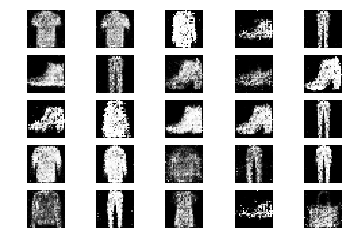

9601 [D loss: 0.638335, acc.: 64.06%] [G loss: 0.910623]
9602 [D loss: 0.645793, acc.: 59.38%] [G loss: 0.955335]
9603 [D loss: 0.667978, acc.: 54.69%] [G loss: 0.913816]
9604 [D loss: 0.611406, acc.: 59.38%] [G loss: 1.032691]
9605 [D loss: 0.760844, acc.: 48.44%] [G loss: 0.934969]
9606 [D loss: 0.667351, acc.: 50.00%] [G loss: 0.894146]
9607 [D loss: 0.673528, acc.: 50.00%] [G loss: 0.961776]
9608 [D loss: 0.652828, acc.: 60.94%] [G loss: 0.943609]
9609 [D loss: 0.632164, acc.: 65.62%] [G loss: 0.902171]
9610 [D loss: 0.589324, acc.: 65.62%] [G loss: 0.958095]
9611 [D loss: 0.654893, acc.: 59.38%] [G loss: 0.952960]
9612 [D loss: 0.582639, acc.: 73.44%] [G loss: 0.955657]
9613 [D loss: 0.633522, acc.: 60.94%] [G loss: 0.870340]
9614 [D loss: 0.591537, acc.: 65.62%] [G loss: 0.920642]
9615 [D loss: 0.639488, acc.: 57.81%] [G loss: 0.874960]
9616 [D loss: 0.578360, acc.: 68.75%] [G loss: 0.876779]
9617 [D loss: 0.653695, acc.: 62.50%] [G loss: 0.960286]
9618 [D loss: 0.597482, acc.: 7

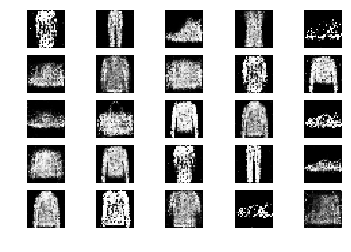

9801 [D loss: 0.569084, acc.: 78.12%] [G loss: 1.024311]
9802 [D loss: 0.689781, acc.: 56.25%] [G loss: 0.931057]
9803 [D loss: 0.698617, acc.: 54.69%] [G loss: 0.904220]
9804 [D loss: 0.676108, acc.: 64.06%] [G loss: 0.875104]
9805 [D loss: 0.577639, acc.: 73.44%] [G loss: 0.889382]
9806 [D loss: 0.628768, acc.: 65.62%] [G loss: 0.937451]
9807 [D loss: 0.624218, acc.: 65.62%] [G loss: 0.972744]
9808 [D loss: 0.684475, acc.: 57.81%] [G loss: 0.878776]
9809 [D loss: 0.635207, acc.: 62.50%] [G loss: 0.845967]
9810 [D loss: 0.593568, acc.: 76.56%] [G loss: 1.011465]
9811 [D loss: 0.677494, acc.: 62.50%] [G loss: 1.084696]
9812 [D loss: 0.597511, acc.: 76.56%] [G loss: 0.880035]
9813 [D loss: 0.598814, acc.: 68.75%] [G loss: 0.987315]
9814 [D loss: 0.656791, acc.: 54.69%] [G loss: 0.858706]
9815 [D loss: 0.642315, acc.: 62.50%] [G loss: 0.980871]
9816 [D loss: 0.664893, acc.: 59.38%] [G loss: 0.988986]
9817 [D loss: 0.689405, acc.: 57.81%] [G loss: 0.948009]
9818 [D loss: 0.652777, acc.: 5

In [0]:
gan = GAN()
gan.train(epochs=10000, batch_size=32, sample_interval=200)

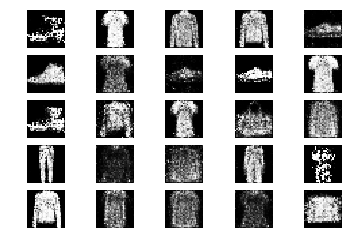

In [0]:
gan.sample_images(100)

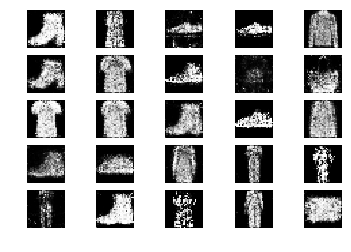

In [0]:
gan.sample_images(1000)

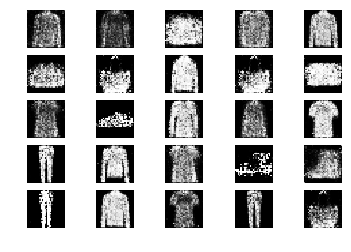

In [0]:
gan.sample_images(10000)

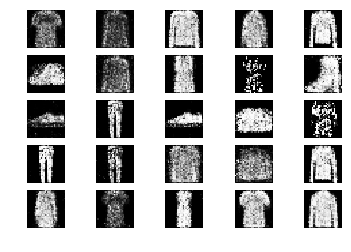

In [0]:
gan.sample_images(100000)

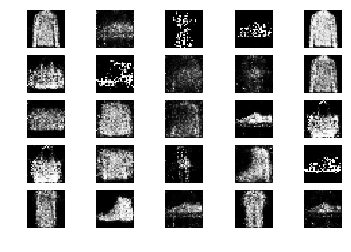

In [0]:
gan.sample_images(100000000)